# Examples 

Notebook with random examples to better visualize results
 

In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
import os
import sys

root_path = os.path.abspath("..")
sys.path.insert(0, root_path)

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

## Simple example 

There are N samples with random labels from a set of M labels. There also samples without any label

In [3]:
n_labels = 5
n_samples = 200

x = np.zeros((n_samples, 2)) # This is not used in the split
y = np.random.randint(0, 2, size=(n_samples, n_labels))

In [4]:
def display_label_distributions(y, title=""):
    plt.figure(figsize=(12, 4))
    plt.title(title)
    plt.bar(list(range(n_labels)), np.sum(y, axis=0))

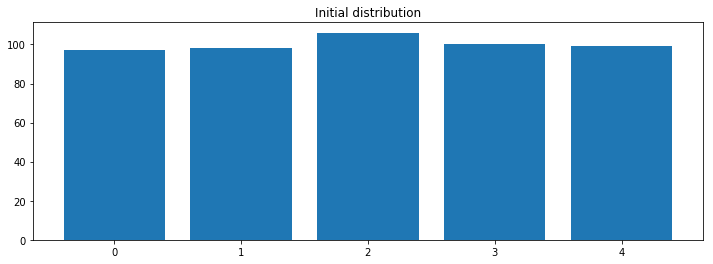

In [5]:
display_label_distributions(y, "Initial distribution")

In [6]:
mskf = MultilabelStratifiedKFold(n_splits=4, random_state=1)

test_indices_list = []
for train_index, test_index in mskf.split(x, y):
    print("TRAIN & TEST = ", set(train_index) & set(test_index))
    y_train = np.sum(y[train_index], axis=0)
    y_train = y_train / np.sum(y_train)
    y_test = np.sum(y[test_index], axis=0)
    y_test = y_test / np.sum(y_test)
    print("TRAIN Y label ratio:", y_train)
    print("TEST Y label ratio:", y_test)
    test_indices_list.append(test_index)

TRAIN & TEST =  set()
TRAIN Y label ratio: [0.19518717 0.19251337 0.21122995 0.20053476 0.20053476]
TEST Y label ratio: [0.19047619 0.20634921 0.21428571 0.1984127  0.19047619]
TRAIN & TEST =  set()
TRAIN Y label ratio: [0.19414894 0.19680851 0.21276596 0.19946809 0.19680851]
TEST Y label ratio: [0.19354839 0.19354839 0.20967742 0.2016129  0.2016129 ]
TRAIN & TEST =  set()
TRAIN Y label ratio: [0.19363395 0.19893899 0.21220159 0.19893899 0.19628647]
TEST Y label ratio: [0.19512195 0.18699187 0.21138211 0.20325203 0.20325203]
TRAIN & TEST =  set()
TRAIN Y label ratio: [0.19302949 0.19571046 0.21179625 0.20107239 0.19839142]
TEST Y label ratio: [0.19685039 0.19685039 0.21259843 0.19685039 0.19685039]


In [7]:
def compute_examples_distrib(test_indices_list, n_samples):
    """
    ED = mean on K folds of abd(S_i - c_i)
    where S_i is number of samples in test fold i
          c_i is desired number of samples = n_samples / n_folds
    """    
    n_folds = len(test_indices_list)
    return np.mean([np.abs(len(test_indices) - (n_samples / n_folds)) for test_indices in test_indices_list])

In [8]:
compute_examples_distrib(test_indices_list, n_samples)

0.5

In [9]:
def compute_label_distrib(test_indices_list, y):
    """
    LD = mean on labels of mean of K folds of abs( S_ij / (S_j - S_ij) - D_i/ (D - D_i) )
    where S_ij is number of positive samples with label i in the test fold j 
          S_j is number of samples in the test fold j 
          D_i is number of positive samples with label i in the whole dataset
          D is number of samples in the whole dataset          
    """
    n_samples = len(y)
    n_labels = y.shape[1]
    output = []
    for i in range(n_labels):
        d_i = np.sum(y[:, i], axis=0)
        d = d_i / (n_samples - d_i)
        out2 = []
        for test_indices in test_indices_list:                
            s_j = len(test_indices)
            s_ij = np.sum(np.sum(y[test_indices, i], axis=0))
            s = s_ij / (s_j - s_ij)
            out2.append(np.abs(s - d))
        output.append(np.mean(out2))
    return np.mean(output)

In [10]:
compute_label_distrib(test_indices_list, y)

0.04852028285723938

## Example with weights

There are N samples with random labels from a set of M labels. There also samples without any label.
However, now labels has a weight property. For example, sample is an image with geometric figures, labels are geometric form types: triangle, square, circle etc, therefore label weight is figure size.

In the following example, let us suppose that all labels have the same weight except two labels that have an imbalanced distribution of weight values:

In [27]:
n_labels = 5
n_samples = 200

x = np.zeros((n_samples, 2)) # This is not used in the split
y = np.random.randint(0, 2, size=(n_samples, n_labels))
# Weights are all equal except the first label
w = 0.5 * np.ones((n_samples, n_labels))
w[:(n_samples*4)//6, 0] = 0.1*np.random.randn((n_samples*4)//6) + 0.7
w[(n_samples*4)//6:, 0] = 0.1*np.random.randn(n_samples - (n_samples*4)//6) + 0.2

w[:(n_samples*2)//3, 1] = 0.05*np.random.randn((n_samples*2)//3) + 0.15
w[(n_samples*2)//3:, 1] = 0.1*np.random.randn(n_samples - (n_samples*2)//3) + 0.8
w = w * y

indices = np.arange(n_samples)
np.random.shuffle(indices)

y = y[indices]
w = w[indices]

In [28]:
y[:5], w[:5]

(array([[0, 1, 1, 0, 0],
        [0, 1, 0, 1, 1],
        [0, 0, 1, 1, 1],
        [1, 1, 1, 0, 1],
        [0, 0, 0, 0, 0]]),
 array([[0.        , 0.82409018, 0.5       , 0.        , 0.        ],
        [0.        , 0.93949995, 0.        , 0.5       , 0.5       ],
        [0.        , 0.        , 0.5       , 0.5       , 0.5       ],
        [0.22438744, 0.8462857 , 0.5       , 0.        , 0.5       ],
        [0.        , 0.        , 0.        , 0.        , 0.        ]]))

In [29]:
def display_weights_distribution(w, title=""):
    plt.figure(figsize=(12, 4))
    plt.title(title)
    n = w.shape[1]
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.hist(w[:, i], bins=20, normed=1)

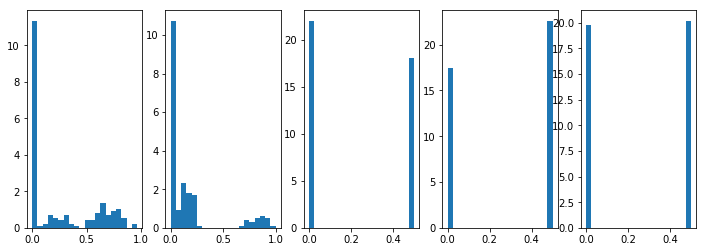

In [30]:
display_weights_distribution(w, "Initial")

In [32]:
mskf = MultilabelStratifiedKFold(n_splits=5, random_state=1, weighted=True)

for train_index, test_index in mskf.split(w, y):
    print("\nTRAIN & TEST = ", set(train_index) & set(test_index))
    y_train = np.sum(y[train_index], axis=0)
    y_train = y_train / np.sum(y_train)
    y_test = np.sum(y[test_index], axis=0)
    y_test = y_test / np.sum(y_test)
    print("TRAIN Y label ratio:", y_train)
    print("TEST Y label ratio:", y_test)

    for i in range(n_labels):
        w_train_hist, _ = np.histogram(w[train_index, i], bins=20, range=(0.01, 1), density=True)
        w_train_hist = w_train_hist / np.sum(w_train_hist)
        w_test_hist, _ = np.histogram(w[test_index, i], bins=20, range=(0.01, 1), density=True)
        w_test_hist = w_test_hist / np.sum(w_test_hist)
        print("TRAIN Label %i - non-zero weights distribution :" % i, w_train_hist)
        print("TEST Label %i - non-zero weights distribution :" % i, w_test_hist)   


TRAIN & TEST =  set()
TRAIN Y label ratio: [0.19023136 0.19280206 0.18508997 0.22622108 0.20565553]
TEST Y label ratio: [0.17821782 0.18811881 0.17821782 0.24752475 0.20792079]
TRAIN Label 0 - non-zero weights distribution : [0.01351351 0.01351351 0.05405405 0.06756757 0.06756757 0.05405405
 0.02702703 0.01351351 0.01351351 0.02702703 0.01351351 0.06756757
 0.13513514 0.14864865 0.05405405 0.12162162 0.06756757 0.01351351
 0.01351351 0.01351351]
TEST Label 0 - non-zero weights distribution : [0.         0.         0.05555556 0.05555556 0.         0.05555556
 0.11111111 0.05555556 0.         0.         0.11111111 0.05555556
 0.16666667 0.05555556 0.05555556 0.11111111 0.05555556 0.05555556
 0.         0.        ]
TRAIN Label 1 - non-zero weights distribution : [0.02666667 0.08       0.32       0.18666667 0.13333333 0.
 0.         0.         0.         0.         0.         0.
 0.         0.02666667 0.02666667 0.04       0.08       0.04
 0.02666667 0.01333333]
TEST Label 1 - non-zero we

In [38]:
mskf = MultilabelStratifiedKFold(n_splits=5, random_state=1, weighted=False)

for train_index, test_index in mskf.split(w, y):
    print("\nTRAIN & TEST = ", set(train_index) & set(test_index))
    y_train = np.sum(y[train_index], axis=0)
    y_train = y_train / np.sum(y_train)
    y_test = np.sum(y[test_index], axis=0)
    y_test = y_test / np.sum(y_test)
    print("TRAIN Y label ratio:", y_train)
    print("TEST Y label ratio:", y_test)

    for i in range(n_labels):
        w_train_hist, _ = np.histogram(w[train_index, i], bins=20, range=(0.01, 1), density=True)
        w_train_hist = w_train_hist / np.sum(w_train_hist)
        w_test_hist, _ = np.histogram(w[test_index, i], bins=20, range=(0.01, 1), density=True)
        w_test_hist = w_test_hist / np.sum(w_test_hist)
        print("TRAIN Label %i - non-zero weights distribution :" % i, w_train_hist[w_train_hist > 0])
        print("TEST Label %i - non-zero weights distribution :" % i, w_test_hist[w_test_hist > 0])   


TRAIN & TEST =  set()
TRAIN Y label ratio: [0.20506329 0.2        0.18987342 0.20506329 0.2       ]
TEST Y label ratio: [0.20408163 0.19387755 0.18367347 0.21428571 0.20408163]
TRAIN Label 0 - non-zero weights distribution : [0.24691358 0.75308642]
TEST Label 0 - non-zero weights distribution : [0.4 0.6]
TRAIN Label 1 - non-zero weights distribution : [0.72151899 0.27848101]
TEST Label 1 - non-zero weights distribution : [0.42105263 0.57894737]
TRAIN Label 2 - non-zero weights distribution : [1.]
TEST Label 2 - non-zero weights distribution : [1.]
TRAIN Label 3 - non-zero weights distribution : [1.]
TEST Label 3 - non-zero weights distribution : [1.]
TRAIN Label 4 - non-zero weights distribution : [1.]
TEST Label 4 - non-zero weights distribution : [1.]

TRAIN & TEST =  set()
TRAIN Y label ratio: [0.20506329 0.2        0.18734177 0.20759494 0.2       ]
TEST Y label ratio: [0.20408163 0.19387755 0.19387755 0.20408163 0.20408163]
TRAIN Label 0 - non-zero weights distribution : [0.271604

Observe that labels are not equally distributed on weight values

In [28]:
np.argsort([5, 6, 7, 2, 3, 0])

array([5, 3, 4, 0, 1, 2])

In [29]:
def WeightedIterativeStratification(labels, weights, r, random_state):
    """This function adapts `ml_stratifiers.IterativeStratification` to the case of weighted labels
    """

    n_samples = labels.shape[0]
    test_folds = np.zeros(n_samples, dtype=int)

    # Calculate the desired number of examples at each subset
    c_folds = r * n_samples

    # Calculate the desired number of examples of each label at each subset
    c_folds_labels = np.outer(r, labels.sum(axis=0))

    labels_not_processed_mask = np.ones(n_samples, dtype=bool)

    while np.any(labels_not_processed_mask):
        # Find the label with the fewest (but at least one) remaining examples,
        # breaking ties randomly
        num_labels = labels[labels_not_processed_mask].sum(axis=0)

        # Handle case where only all-zero labels are left by distributing
        # across all folds as evenly as possible (not in original algorithm but
        # mentioned in the text). (By handling this case separately, some
        # code redundancy is introduced; however, this approach allows for
        # decreased execution time when there are a relatively large number
        # of all-zero labels.)
        if num_labels.sum() == 0:
            sample_idxs = np.where(labels_not_processed_mask)[0]

            for sample_idx in sample_idxs:
                fold_idx = np.where(c_folds == c_folds.max())[0]

                if fold_idx.shape[0] > 1:
                    fold_idx = fold_idx[random_state.choice(fold_idx.shape[0])]

                test_folds[sample_idx] = fold_idx
                c_folds[fold_idx] -= 1

            break

        label_idx = np.where(num_labels == num_labels[np.nonzero(num_labels)].min())[0]
        if label_idx.shape[0] > 1:
            label_idx = label_idx[random_state.choice(label_idx.shape[0])]

        sample_idxs = np.where(np.logical_and(labels[:, label_idx].flatten(), labels_not_processed_mask))[0]

        # Order sample indices by descending weights
        label_weights = weights[:, label_idx].flatten()
        ordered_sample_indxs = np.argsort(label_weights)[::-1]
        sample_idxs = ordered_sample_indxs[np.isin(ordered_sample_indxs, sample_idxs)]

        for sample_idx in sample_idxs:
            # Find the subset(s) with the largest number of desired examples
            # for this label, breaking ties by considering the largest number
            # of desired examples, breaking further ties randomly
            label_folds = c_folds_labels[:, label_idx]
            fold_idx = np.where(label_folds == label_folds.max())[0]

            if fold_idx.shape[0] > 1:
                temp_fold_idx = np.where(c_folds[fold_idx] ==
                                         c_folds[fold_idx].max())[0]
                fold_idx = fold_idx[temp_fold_idx]

                if temp_fold_idx.shape[0] > 1:
                    fold_idx = fold_idx[random_state.choice(temp_fold_idx.shape[0])]

            test_folds[sample_idx] = fold_idx
            labels_not_processed_mask[sample_idx] = False

            # Update desired number of examples
            c_folds_labels[fold_idx, labels[sample_idx]] -= 1
            c_folds[fold_idx] -= 1

    return test_folds

In [30]:
r = np.asarray([1 / 5] * 5)
test_folds = WeightedIterativeStratification(y, w, r, random_state=np.random.RandomState())

In [37]:

for fold_index in range(5):
    test_index = np.where(test_folds == fold_index)[0]
    train_index = np.where(test_folds != fold_index)[0]

    # for train_index, test_index in mskf.split(w, y):
    print("\nTRAIN & TEST = ", set(train_index) & set(test_index))
    y_train = np.sum(y[train_index], axis=0)
    y_train = y_train / np.sum(y_train)
    y_test = np.sum(y[test_index], axis=0)
    y_test = y_test / np.sum(y_test)
    print("TRAIN Y label ratio:", y_train)
    print("TEST Y label ratio:", y_test)

    for i in range(n_labels):
        w_train_hist, _ = np.histogram(w[train_index, i], bins=20, range=(0.01, 1), density=True)
        w_train_hist = w_train_hist / np.sum(w_train_hist)
        w_test_hist, _ = np.histogram(w[test_index, i], bins=20, range=(0.01, 1), density=True)
        w_test_hist = w_test_hist / np.sum(w_test_hist)
        print("TRAIN Label %i - non-zero weights distribution :" % i, w_train_hist[w_train_hist > 0])
        print("TEST Label %i - non-zero weights distribution :" % i, w_test_hist[w_test_hist > 0])  


TRAIN & TEST =  set()
TRAIN Y label ratio: [0.20854271 0.19849246 0.18592965 0.20100503 0.20603015]
TEST Y label ratio: [0.18947368 0.2        0.2        0.23157895 0.17894737]
TRAIN Label 0 - non-zero weights distribution : [0.27710843 0.72289157]
TEST Label 0 - non-zero weights distribution : [0.27777778 0.72222222]
TRAIN Label 1 - non-zero weights distribution : [0.70886076 0.29113924]
TEST Label 1 - non-zero weights distribution : [0.47368421 0.52631579]
TRAIN Label 2 - non-zero weights distribution : [1.]
TEST Label 2 - non-zero weights distribution : [1.]
TRAIN Label 3 - non-zero weights distribution : [1.]
TEST Label 3 - non-zero weights distribution : [1.]
TRAIN Label 4 - non-zero weights distribution : [1.]
TEST Label 4 - non-zero weights distribution : [1.]

TRAIN & TEST =  set()
TRAIN Y label ratio: [0.20716113 0.20204604 0.19181586 0.20460358 0.1943734 ]
TEST Y label ratio: [0.19607843 0.18627451 0.17647059 0.21568627 0.2254902 ]
TRAIN Label 0 - non-zero weights distributi